# Univariate Gaussianization

In [1]:
#@title Install Packages
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here", "setup.py"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os
    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as np
from jax.config import config
import chex
config.update("jax_enable_x64", False)

import numpy as onp
from functools import partial

# library parameters
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_info_loss, plot_joint, plot_joint_prob

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# get data
n_samples = 1_000
n_features = 1
data = get_classic(n_samples)

## Initialization

First we need to initialize our RBIG method with some parameters. For example, which marginal gaussianization method, what precision do we want, and what rotation method do we want.

* `method` - the method used to marginally transform the data. We have histogram or kde currently implemented
* `support_extension` - this is the amount we want to extend the support for our marginal distributions. Higher values indicate higher
* `precision` - we use interpolation because it is much faster. So the CDF, PDF and PPF are interpolation schemes. This value will allow one to have more "precision" for the estimated quantities but it will be slower.

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

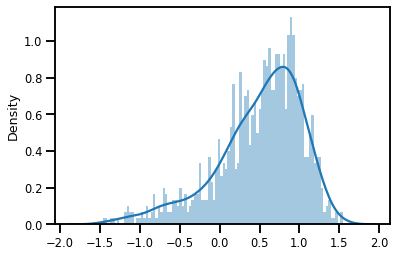

In [4]:
X = np.array(data[:, 1], dtype=np.float32)

sns.distplot(X, bins=100)

## Histogram Uniformization

In [56]:
from rbig_jax.transforms.histogram import InitUniHistTransform
from rbig_jax.transforms.kde import InitKDEUniformize

support_extension = 50
alpha = 1e-5
precision = 1_000
nbins = int(np.sqrt(X.shape[0]))

# initialize histogram transformation
init_hist_func = InitUniHistTransform(
    n_samples=X.shape[0],
    nbins=nbins,
    support_extension=support_extension,
    precision=precision,
    alpha=alpha
)

#### Initialize + Forward Transform

In [57]:
X_u, hist_bijector = init_hist_func(X)

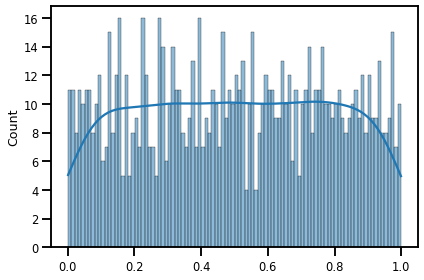

In [58]:
fig, ax = plt.subplots()
sns.histplot(X_u, bins=100, kde=True, ax=ax)
plt.tight_layout()
plt.show()

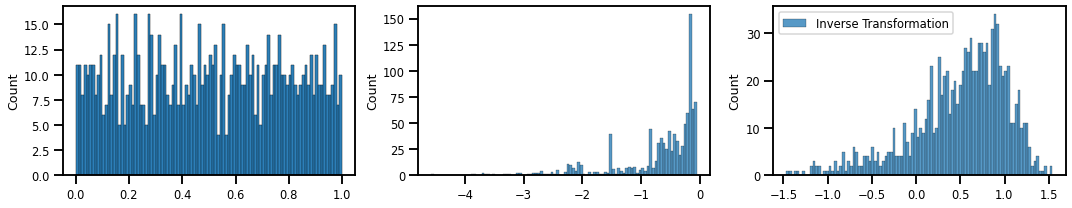

In [61]:
X_u, hist_bijector = init_hist_func(X)
X_u_ = hist_bijector.forward(X)
X_approx = hist_bijector.inverse(X_u)
X_u_ldj = hist_bijector.forward_log_det_jacobian(X)

fig, ax = plt.subplots(ncols=3, figsize=(15, 3))
sns.histplot(X_u, bins=100, label="Latent Space", ax=ax[0])
sns.histplot(X_u_, bins=100, label="Latent Space (Transform)", ax=ax[0])
sns.histplot(X_u_ldj, bins=100, label="Gradient", ax=ax[1])
sns.histplot(X_approx, bins=100, label="Inverse Transformation", ax=ax[2])
plt.legend()
plt.tight_layout()
plt.show()

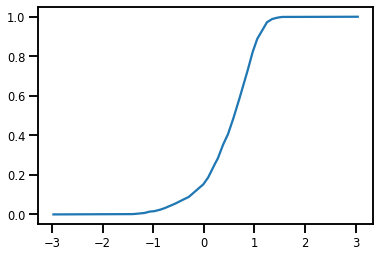

In [8]:
plt.plot(hist_bijector.support, hist_bijector.quantiles)

#### JIT

In [14]:
# JIT Compile (OPTIONAL)
init_f_jitted = jax.jit(init_hist_func)

In [15]:
X_u, hist_params = init_f_jitted(X) 
%timeit init_hist_func(X.block_until_ready())
%timeit init_f_jitted(X.block_until_ready()) 

78.2 ms ± 514 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
89.6 µs ± 1.41 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Forward Transformation

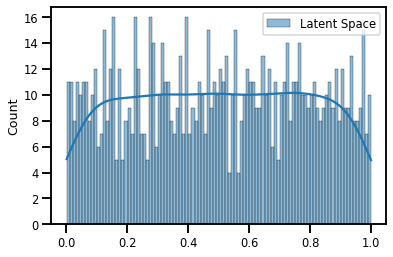

In [16]:
X_u = hist_bijector.forward(X)

sns.histplot(X_u, bins=100, label="Latent Space", kde=True)
plt.legend()

### Inverse Transformation

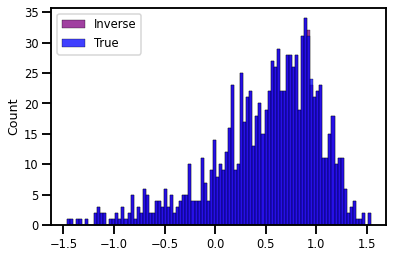

In [17]:
X_approx = hist_bijector.inverse(X_u)


sns.histplot(X_approx, bins=100, label="Inverse", color="purple")
sns.histplot(X, bins=100, label="True", color="blue")
plt.legend()

### Jacobian

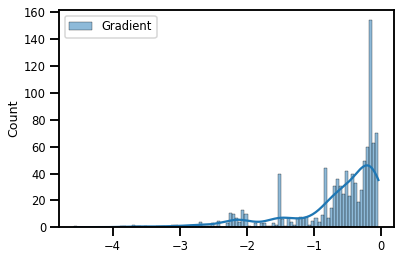

In [18]:
X_ldj_u = hist_bijector.forward_log_det_jacobian(X)


plt.figure()
sns.histplot(X_ldj_u, bins=100, label="Gradient", kde=True)
plt.legend()
plt.show()

## Inverse CDF Estimation

#### Logit

In [49]:
# Logit transform
from rbig_jax.transforms.logit import InitLogitTransform

init_logit_func = InitLogitTransform()

#### Init + Transform

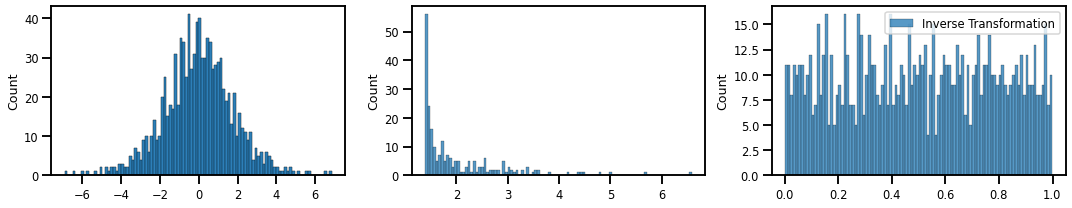

In [51]:
X_g, logit_bijector = init_logit_func(X_u, None, None)
X_g_ = logit_bijector.forward(X_u)
X_u_approx = logit_bijector.inverse(X_g)
X_g_ldj = logit_bijector.forward_log_det_jacobian(X_g)

fig, ax = plt.subplots(ncols=3, figsize=(15, 3))
sns.histplot(X_g, bins=100, label="Latent Space", ax=ax[0])
sns.histplot(X_g_, bins=100, label="Latent Space (Transform)", ax=ax[0])
sns.histplot(X_g_ldj, bins=100, label="Gradient", ax=ax[1])
sns.histplot(X_u_approx, bins=100, label="Inverse Transformation", ax=ax[2])
plt.legend()
plt.tight_layout()
plt.show()

### Inverse Gaussian CDF

In [52]:
from rbig_jax.transforms.inversecdf import InitInverseGaussCDFTransform

# univariate normalization Gaussianization parameters
eps = 1e-5

# initialize histogram transformation
init_icdf_func = InitInverseGaussCDFTransform(eps=eps)

### Transformations

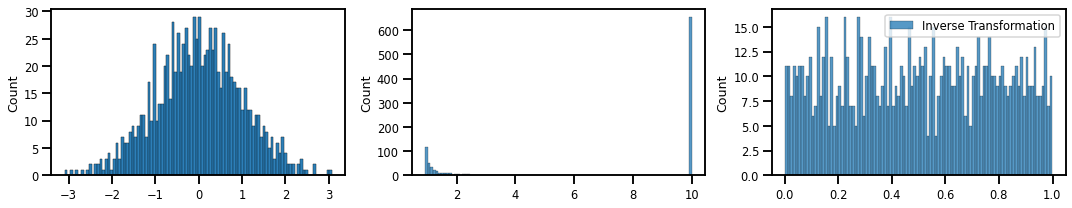

In [53]:
X_g, icdf_bijector = init_icdf_func(X_u, None, None)
X_g_ = icdf_bijector.forward(X_u)
X_u_approx = icdf_bijector.inverse(X_g)
X_g_ldj = icdf_bijector.forward_log_det_jacobian(X_g)

fig, ax = plt.subplots(ncols=3, figsize=(15, 3))
sns.histplot(X_g, bins=100, label="Latent Space", ax=ax[0])
sns.histplot(X_g_, bins=100, label="Latent Space (Transform)", ax=ax[0])
sns.histplot(X_g_ldj, bins=100, label="Gradient", ax=ax[1])
sns.histplot(X_u_approx, bins=100, label="Inverse Transformation", ax=ax[2])
plt.legend()
plt.tight_layout()
plt.show()

### Stacking Transformations Together

#### Example I - Histogram + Logit

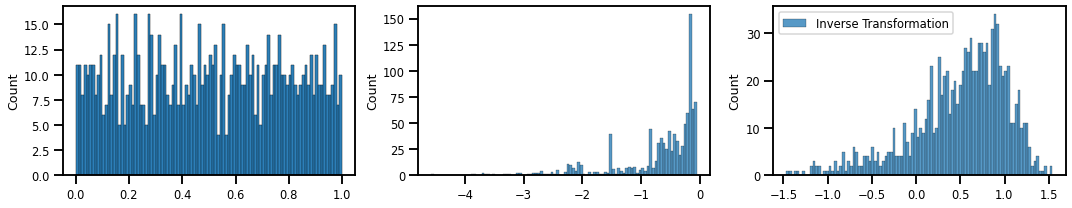

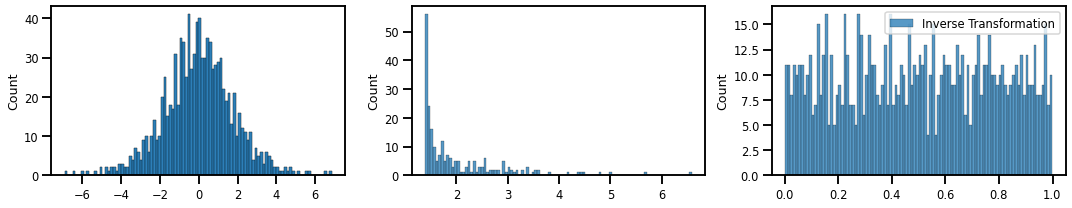

In [65]:
X_u, hist_bijector = init_hist_func(X)
X_u_ = hist_bijector.forward(X)
X_approx = hist_bijector.inverse(X_u)
X_u_ldj = hist_bijector.forward_log_det_jacobian(X)

fig, ax = plt.subplots(ncols=3, figsize=(15, 3))
sns.histplot(X_u, bins=100, label="Latent Space", ax=ax[0])
sns.histplot(X_u_, bins=100, label="Latent Space (Transform)", ax=ax[0])
sns.histplot(X_u_ldj, bins=100, label="Gradient", ax=ax[1])
sns.histplot(X_approx, bins=100, label="Inverse Transformation", ax=ax[2])
plt.legend()
plt.tight_layout()
plt.show()

X_g, logit_bijector = init_logit_func(X_u, None, None)
X_g_ = logit_bijector.forward(X_u)
X_u_approx = logit_bijector.inverse(X_g)
X_g_ldj = logit_bijector.forward_log_det_jacobian(X_g)

fig, ax = plt.subplots(ncols=3, figsize=(15, 3))
sns.histplot(X_g, bins=100, label="Latent Space", ax=ax[0])
sns.histplot(X_g_, bins=100, label="Latent Space (Transform)", ax=ax[0])
sns.histplot(X_g_ldj, bins=100, label="Gradient", ax=ax[1])
sns.histplot(X_u_approx, bins=100, label="Inverse Transformation", ax=ax[2])
plt.legend()
plt.tight_layout()
plt.show()

#### Example II - Inverse Gauss CDF

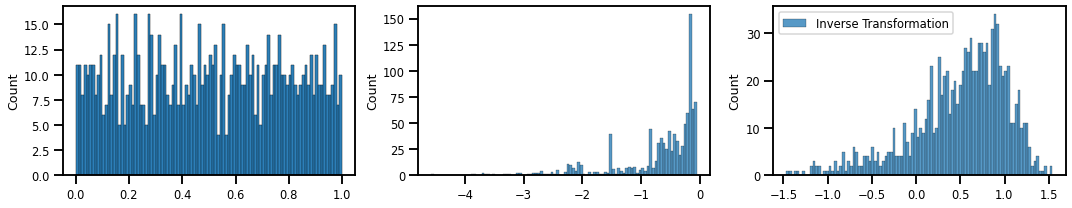

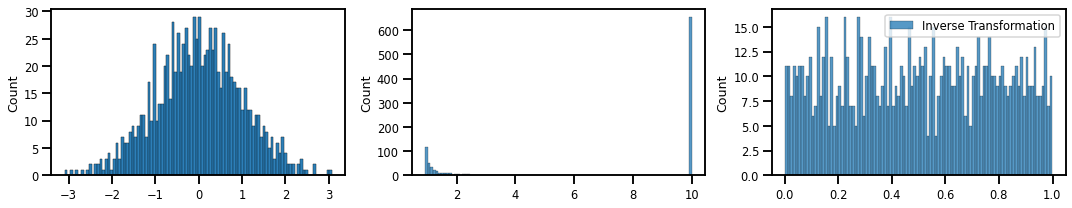

In [64]:
X_u, hist_bijector = init_hist_func(X)
X_u_ = hist_bijector.forward(X)
X_approx = hist_bijector.inverse(X_u)
X_u_ldj = hist_bijector.forward_log_det_jacobian(X)

fig, ax = plt.subplots(ncols=3, figsize=(15, 3))
sns.histplot(X_u, bins=100, label="Latent Space", ax=ax[0])
sns.histplot(X_u_, bins=100, label="Latent Space (Transform)", ax=ax[0])
sns.histplot(X_u_ldj, bins=100, label="Gradient", ax=ax[1])
sns.histplot(X_approx, bins=100, label="Inverse Transformation", ax=ax[2])
plt.legend()
plt.tight_layout()
plt.show()


X_g, icdf_bijector = init_icdf_func(X_u, None, None)
X_g_ = icdf_bijector.forward(X_u)
X_u_approx = icdf_bijector.inverse(X_g)
X_g_ldj = icdf_bijector.forward_log_det_jacobian(X_g)

fig, ax = plt.subplots(ncols=3, figsize=(15, 3))
sns.histplot(X_g, bins=100, label="Latent Space", ax=ax[0])
sns.histplot(X_g_, bins=100, label="Latent Space (Transform)", ax=ax[0])
sns.histplot(X_g_ldj, bins=100, label="Gradient", ax=ax[1])
sns.histplot(X_u_approx, bins=100, label="Inverse Transformation", ax=ax[2])
plt.legend()
plt.tight_layout()
plt.show()

#### Example III - Sigmoid + Histogram + Logit

In [66]:
from distrax._src.bijectors.sigmoid import Sigmoid

In [67]:
sigmoid_bijector = Sigmoid()

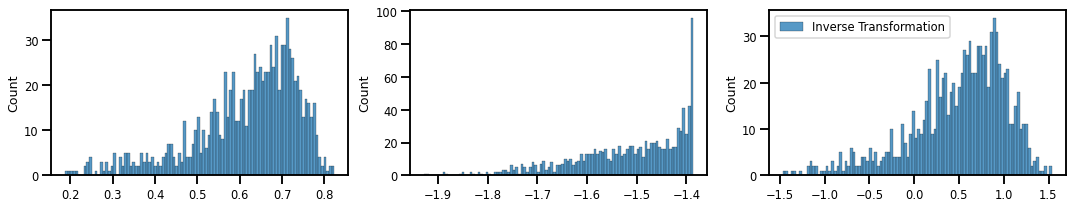

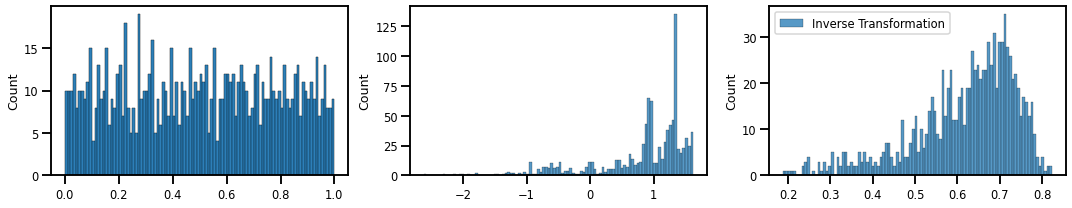

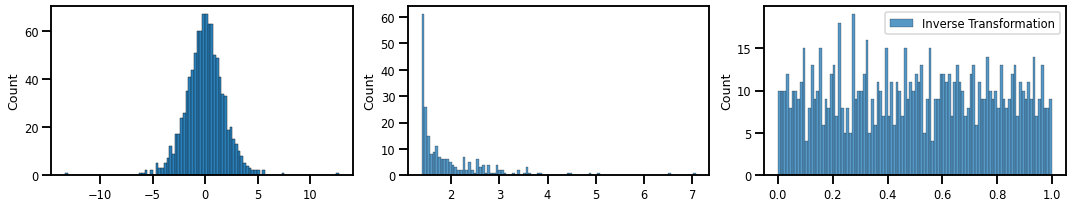

In [75]:
X_u = sigmoid_bijector.forward(X)
X_approx = sigmoid_bijector.inverse(X_u)
X_u_ldj = sigmoid_bijector.forward_log_det_jacobian(X)

fig, ax = plt.subplots(ncols=3, figsize=(15, 3))
sns.histplot(X_u, bins=100, label="Latent Space", ax=ax[0])
sns.histplot(X_u_ldj, bins=100, label="Gradient", ax=ax[1])
sns.histplot(X_approx, bins=100, label="Inverse Transformation", ax=ax[2])
plt.legend()
plt.tight_layout()
plt.show()

# ==========================
# HISTOGRAM
# ==========================
support_extension = 1e-5
alpha = 1e-5
precision = 100
nbins = int(np.sqrt(X.shape[0]))

# initialize histogram transformation
init_hist_func = InitUniHistTransform(
    n_samples=X.shape[0],
    nbins=nbins,
    support_extension=support_extension,
    precision=precision,
    alpha=alpha
)

X_u_l2, hist_bijector = init_hist_func(X_u)
X_u_l2_ = hist_bijector.forward(X_u)
X_u_approx = hist_bijector.inverse(X_u_l2)
X_u_ldj = hist_bijector.forward_log_det_jacobian(X_u)

fig, ax = plt.subplots(ncols=3, figsize=(15, 3))
sns.histplot(X_u_l2, bins=100, label="Latent Space", ax=ax[0])
sns.histplot(X_u_l2_, bins=100, label="Latent Space (Transform)", ax=ax[0])
sns.histplot(X_u_ldj, bins=100, label="Gradient", ax=ax[1])
sns.histplot(X_u_approx, bins=100, label="Inverse Transformation", ax=ax[2])
plt.legend()
plt.tight_layout()
plt.show()


X_g, logit_bijector = init_logit_func(X_u_l2, None, None)
X_g_ = logit_bijector.forward(X_u_l2)
X_u_approx = logit_bijector.inverse(X_g)
X_g_ldj = logit_bijector.forward_log_det_jacobian(X_g)

fig, ax = plt.subplots(ncols=3, figsize=(15, 3))
sns.histplot(X_g, bins=100, label="Latent Space", ax=ax[0])
sns.histplot(X_g_, bins=100, label="Latent Space (Transform)", ax=ax[0])
sns.histplot(X_g_ldj, bins=100, label="Gradient", ax=ax[1])
sns.histplot(X_u_approx, bins=100, label="Inverse Transformation", ax=ax[2])
plt.legend()
plt.tight_layout()
plt.show()